# Training the Model for Character Recognition

In [43]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255, width_shift_range=0.1, height_shift_range=0.1)
train_generator = train_datagen.flow_from_directory(
        './data/train',  # this is the target directory
        target_size=(28,28),  # all images will be resized to 28x28
        batch_size=1,
        class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
        './data/val',  # this is the target directory
        target_size=(28,28),  # all images will be resized to 28x28        batch_size=1,
        class_mode='categorical')

Found 1728 images belonging to 36 classes.
Found 216 images belonging to 36 classes.


In [44]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Dropout, Conv2D
from tensorflow.keras import optimizers

In [45]:
model = Sequential()
model.add(Conv2D(32, (24,24), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(36, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=0.00001), metrics=['accuracy'])

C:\Users\Tushar\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [46]:
class stop_training_callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('val_acc') is not None and logs.get('val_acc') > 0.992:
      self.model.stop_training = True

In [47]:
import datetime
!rm -rf logs
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [48]:
batch_size = 1
callbacks = [tensorboard_callback, stop_training_callback()]
model.fit_generator(
      train_generator,
      steps_per_epoch = train_generator.samples // batch_size,
      validation_data = validation_generator, 
      validation_steps = validation_generator.samples // batch_size,
      epochs = 15, callbacks=callbacks)

C:\Users\Tushar\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
1728/1728 [==============================] - 26s 15ms/step - loss: 3.3740 - accuracy: 0.1285 - val_loss: 2.9637 - val_accuracy: 0.3657
Epoch 2/15
1728/1728 [==============================] - 21s 12ms/step - loss: 2.4262 - accuracy: 0.3889
Epoch 3/15
1728/1728 [==============================] - 21s 12ms/step - loss: 1.6077 - accuracy: 0.5689
Epoch 4/15
1728/1728 [==============================] - 21s 12ms/step - loss: 1.2090 - accuracy: 0.6655
Epoch 5/15
1728/1728 [==============================] - 20s 12ms/step - loss: 0.9875 - accuracy: 0.7193
Epoch 6/15
1728/1728 [==============================] - 21s 12ms/step - loss: 0.7893 - accuracy: 0.7697
Epoch 7/15
1728/1728 [==============================] - 22s 13ms/step - loss: 0.6301 - accuracy: 0.8113
Epoch 8/15
1728/1728 [==============================] - 22s 13ms/step - loss: 0.5781 - accuracy: 0.8328
Epoch 9/15
1728/1728 [==============================] - 22s 13ms/step - loss: 0.5012 - accuracy: 0.8495
Epoch 10/15
1728/1728 

In [42]:
%tensorboard --logdir logs/fit

UsageError: Line magic function `%tensorboard` not found.


In [63]:
from tensorflow import keras
model.save('licence-plate.pkl')

INFO:tensorflow:Assets written to: licence-plate.pkl\assets


In [49]:
from tensorflow import keras
model = keras.models.load_model('licence-plate.pkl')

# Extracting the plate from Captured Image

In [50]:
import matplotlib.pyplot as plt
def extract_plate(img): # the function detects and perfors blurring on the number plate.
    plate_img = img.copy()
    plate = None
    #Loads the data required for detecting the license plates from cascade classifier.
    plate_cascade = cv2.CascadeClassifier('./indian_license_plate.xml')

    # detects numberplates and returns the coordinates and dimensions of detected license plate's contours.
    plate_rect = plate_cascade.detectMultiScale(plate_img, scaleFactor = 1.3, minNeighbors = 7)

    for (x,y,w,h) in plate_rect:
        a,b = (int(0.02*img.shape[0]), int(0.025*img.shape[1])) #parameter tuning
        plate = plate_img[y+a:y+h-a, x+b:x+w-b, :]
        # finally representing the detected contours by drawing rectangles around the edges.
        cv2.rectangle(plate_img, (x,y), (x+w, y+h), (51,51,255), 3)
        
    return plate_img, plate # returning the processed image.

# Finding the contours in extracted image of plate

In [51]:
import numpy as np
import cv2

# Match contours to license plate or character template
def find_contours(dimensions, img) :

    # Find all contours in the image
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    
    # Check largest 5 or  15 contours for license plate or character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]
    
    ii = cv2.imread('contour.jpg')
    
    x_cntr_list = []
    #target_contours = []
    img_res = []
    for cntr in cntrs :
        #detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        
        #checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX) #stores the x coordinate of the character's contour, to used later for indexing the contours

            char_copy = np.zeros((44,24))
            #extracting each character using the enclosing rectangle's coordinates.
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))
            
            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
            plt.imsave('countour_rect.jpg', ii, format='jpg')

            # Make result formatted for classification: invert colors
            char = cv2.subtract(255, char)

            # Resize the image to 24x44 with black border
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0
            img_res.append(char_copy) #List that stores the character's binary image (unsorted)

    #Return characters on ascending order with respect to the x-coordinate (most-left character first)

    #arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])# stores character images according to their index
    img_res = np.array(img_res_copy)
    return img_res

# Find characters in the resulting images

In [52]:
def segment_characters(image) :

    # Preprocess cropped license plate image
    img_lp = cv2.resize(image, (333, 75))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))

    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]

    # Make borders white
    img_binary_lp[0:3,:] = 255
    img_binary_lp[:,0:3] = 255
    img_binary_lp[72:75,:] = 255
    img_binary_lp[:,330:333] = 255

    # Estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH/6,
                       LP_WIDTH/2,
                       LP_HEIGHT/10,
                       2*LP_HEIGHT/3]
    cv2.imwrite('contour.jpg',img_binary_lp)

    # Get contours within cropped license plate
    char_list = find_contours(dimensions, img_binary_lp)

    return char_list

# Capturing the live image

In [77]:
import cv2
cap = cv2.VideoCapture(0)
while True:
    ret,img = cap.read()
    cv2.imshow('Image', img)
    plate_img, plate = extract_plate(img)
    if plate is None:
        print("Licence Plate not found")
    else:
        cv2.imwrite('licence-plate.jpg', plate)
        plate = cv2.imread('licence-plate.jpg')
        char = segment_characters(plate)
        if len(char) != 0:
            cv2.imshow('Image', plate_img)
        if len(char) == 10:
           cv2.imshow('Image', plate_img)
           break
    if cv2.waitKey(50) == 13:
        break
cv2.destroyAllWindows()
cap.release()

Licence Plate not found


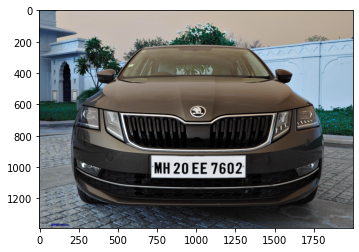

In [74]:
img = cv2.imread('car.jpg')
plt.imshow(img)
plate_img, plate = extract_plate(img)
char = segment_characters(plate)

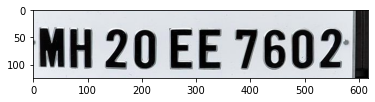

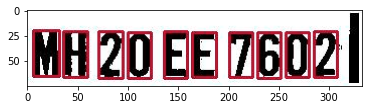

In [75]:
plt.imshow(plate)
plt.show()
img = cv2.imread('countour_rect.jpg')
plt.imshow(img)

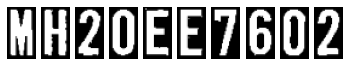

In [76]:
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(char[i], cmap='gray')
    plt.axis('off')

# Prediction

In [72]:
def fix_dimension(img): 
  new_img = np.zeros((28,28,3))
  for i in range(3):
    new_img[:,:,i] = img
  return new_img
  
def show_results():
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i,c in enumerate(characters):
        dic[i] = c

    output = []
    for i,ch in enumerate(char): #iterating over the characters
        img_ = cv2.resize(ch, (28,28))
        img = fix_dimension(img_)
        img = img.reshape(1,28,28,3) #preparing image for the model
        #y_ = model.predict_classes(img)[0] #predicting the class
        predict_x=model.predict(img)[0] 
        y=np.argmax(predict_x)
        character = dic[y] #
        output.append(character) #storing the result in a list
        
    plate_number = ''.join(output)
    
    return plate_number

plate_number = show_results()[:10]
char = char[:10]
print("Licence Plate Number:- ", plate_number)

Licence Plate Number:-  MH20EE7602


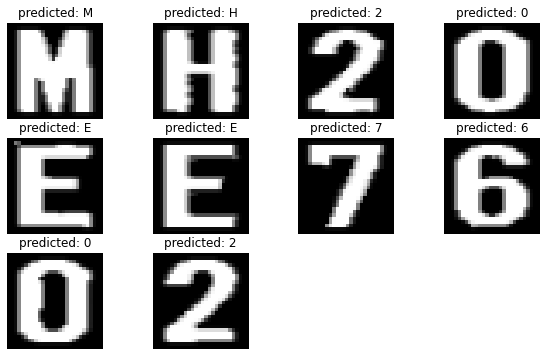

In [73]:
plt.figure(figsize=(10,6))
for i,ch in enumerate(char):
    img = cv2.resize(ch, (28,28))
    plt.subplot(3,4,i+1)
    plt.imshow(img,cmap='gray')
    plt.title(f'predicted: {plate_number[i]}')
    plt.axis('off')
plt.show()

# Using API to get details about the vehicle

In [59]:
plate_number

'MH20EE7602'

In [62]:
import requests
import xmltodict
import json
def get_vehicle_info(plate_number):
    r = requests.get("https://www.regcheck.org.uk/api/reg.asmx/CheckIndia?RegistrationNumber={}&username=tusharbirari04".format(str(plate_number)))
    print(r)
    data = xmltodict.parse(r.content)
    jdata = json.dumps(data)
    df = json.loads(jdata)
    df1 = json.loads(df['Vehicle']['vehicleJson'])
    return df1

In [63]:
get_vehicle_info(plate_number)

<Response [200]>


{'Description': 'SKODA OCTAVIA STYLE PLUS 1.8 TSI AT',
 'RegistrationYear': '2017',
 'CarMake': {'CurrentTextValue': 'SKODA'},
 'CarModel': {'CurrentTextValue': 'OCTAVIA'},
 'Variant': 'STYLE PLUS 1.8 TSI AT',
 'EngineSize': {'CurrentTextValue': '1798'},
 'MakeDescription': {'CurrentTextValue': 'SKODA'},
 'ModelDescription': {'CurrentTextValue': 'OCTAVIA'},
 'NumberOfSeats': {'CurrentTextValue': '5'},
 'VechileIdentificationNumber': 'TMBBDCNE0HA006325',
 'EngineNumber': 'CJS202896',
 'FuelType': {'CurrentTextValue': 'Petrol'},
 'RegistrationDate': '19-MAY-17',
 'Owner': '',
 'Fitness': '',
 'Insurance': '',
 'PUCC': '',
 'VehicleType': 'MOTOR CAR(LMV)',
 'Location': 'RTO,AURANGABAD',
 'ImageUrl': 'http://www.carregistrationapi.in/image.aspx/@U0tPREEgT0NUQVZJQSBTVFlMRSBQTFVTIDEuOCBUU0kgQVQ='}